# Tutorial 2: Plotting Guide

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ADSCIAN/vassal/blob/main/notebooks/02_ssa_plotting_guide.ipynb)

Jump to:

* [`kind='matrix'`](#Matrix-Plot)

In [1]:
#!pip install git+https://github.com/ADSCIAN/ssalib.git # Uncomment to install if needed

from ssalib import SingularSpectrumAnalysis as SSA
from ssalib.datasets import load_sst

#help(SingularSpectrumAnalysis.plot)  # uncomment to get help

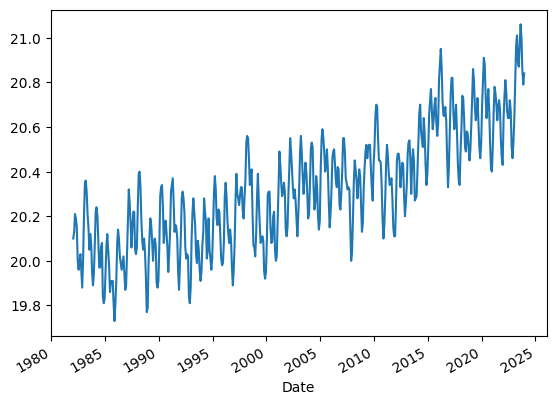

In [2]:
sst = load_sst()
_ = sst.plot()

## Plot Kinds

### Matrix Plot

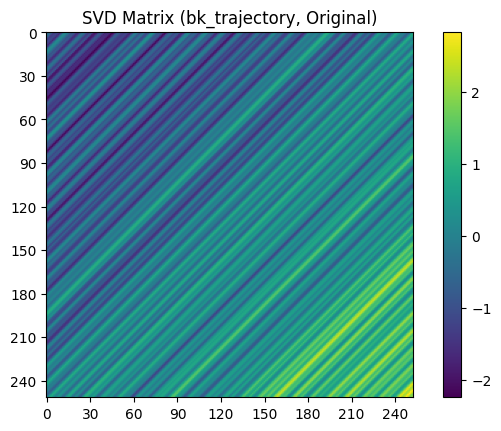

In [3]:
ssa_bk = SSA(sst) # svd_matrix_kind is 'bk_trajectory' by default
_ = ssa_bk.plot(kind='matrix')

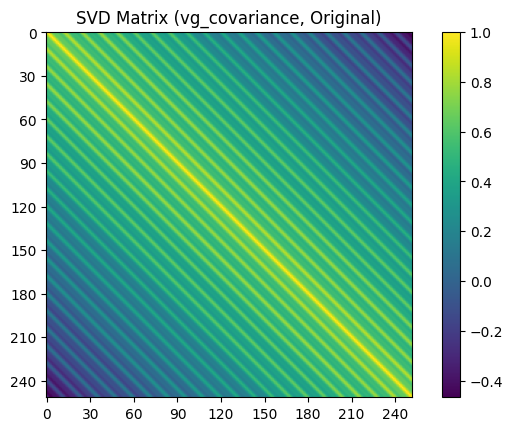

In [4]:
ssa_vg = SSA(sst, svd_matrix_kind='vg_covariance')
_ = ssa_vg.plot(kind='matrix')

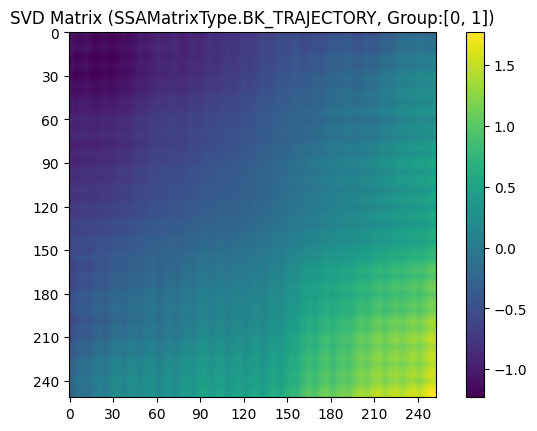

In [6]:
ssa_bk.decompose()
_ = ssa_bk.plot(kind='matrix', indices=[0,1]) #TODO: deal with title